In [427]:
import numpy as np
import matplotlib.pyplot as plt

In [428]:
waypoints = np.array([[0,0,0,0,0,0],
                    [1,1,1,0.1,0.45,1.57]])

In [429]:
from scipy.spatial.transform import Rotation as R

def euler_to_quaternion(x, y, z):
    """
    Converts Euler angles (XYZ fixed angles) to quaternion.
    """
    rotation = R.from_euler('xyz', [x, y, z])  # Use degrees=True for convenience
    return rotation.as_quat()  # Returns [x, y, z, w]

def quaternion_distance(q1, q2):
    """
    Computes the geodesic distance between two quaternions.
    This is defined as the angle of rotation required to go from q1 to q2.
    """
    dot_product = np.dot(q1, q2)  # Inner product of quaternions
    dot_product = np.clip(dot_product, -1.0, 1.0)  # Ensure within valid range for acos
    return 2 * np.arccos(abs(dot_product))  # Angle in radians

In [430]:
path_length = np.zeros(len(waypoints)-1)
orientation_length = np.zeros(len(waypoints)-1)
for i in range(1,len(waypoints)):
    path_length[i-1] = np.linalg.norm(waypoints[i,:3] - waypoints[i-1,:3])
    orientation_length[i-1] = quaternion_distance(euler_to_quaternion(*waypoints[i-1,3:]),euler_to_quaternion(*waypoints[i,3:]))


In [431]:
total_length = path_length[0] if (path_length[0]>orientation_length[0]) else orientation_length[0]
print("Path Length: ", path_length)
print("Orientation Length: ", orientation_length)
print("Total Length: ", total_length)

Path Length:  [1.73205081]
Orientation Length:  [1.60035958]
Total Length:  1.7320508075688772


# Trapezoidal Planner

In [432]:
class TrapezoidalPlanner:
    def __init__(self,a_max,v_max,t_acc,t_dec,t_vel):
        self.a_max = a_max
        self.v_max = v_max
        self.t_acc = t_acc
        self.t_dec = t_dec
        self.t_vel = t_vel
    def trapezoidal_planner(self,t):
        if(t<self.t_acc):
            s = 0.5*self.a_max*t**2
        elif(t<self.t_acc+self.t_vel):
            s = 0.5*self.a_max*self.t_acc**2 + self.v_max*(t-self.t_acc)
        else:
            s = 0.5*self.a_max*self.t_acc**2 + self.v_max*self.t_vel + 0.5*(2*self.v_max-self.a_max*(t-self.t_acc-self.t_vel))*(t-self.t_acc-self.t_vel)
        return s

In [433]:
v_max = 1
a_max = 2
t_acc = v_max/a_max
t_dec = v_max/a_max
t_vel = (total_length - v_max*t_acc - v_max*t_dec)/v_max
total_time = t_acc + t_vel + t_dec

trap = TrapezoidalPlanner(a_max,v_max,t_acc,t_dec,t_vel)
print("Acceleration Time: ", t_acc)
print("Deceleration Time: ", t_dec)
print("Constant Velocity Time: ", t_vel)
print("Total Time: ", total_time)

Acceleration Time:  0.5
Deceleration Time:  0.5
Constant Velocity Time:  0.7320508075688772
Total Time:  1.7320508075688772


In [434]:
time_arr = np.arange(0,total_time,0.001)
s_arr = []
for t in time_arr:
    s_arr.append(trap.trapezoidal_planner(t))
s_arr = np.array(s_arr)

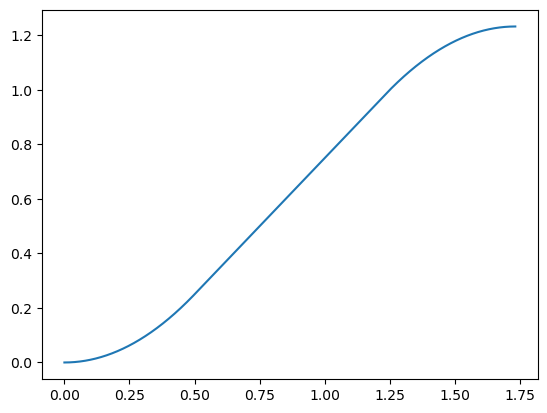

In [435]:
plt.plot(time_arr,s_arr)

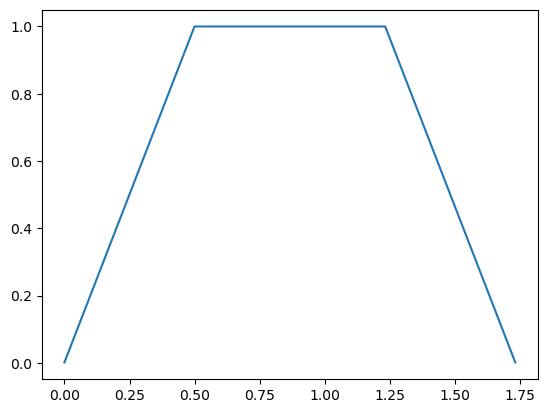

In [436]:
plt.plot(time_arr[:-1],np.diff(s_arr)/np.diff(time_arr))

## Path Planning

In [437]:
import numpy as np
from scipy.spatial.transform import Rotation as R, Slerp

def slerp_quaternions(q1, q2, t_values):
    """
    Performs Spherical Linear Interpolation (SLERP) between two quaternions.

    Parameters:
        q1, q2: numpy arrays representing the start and end quaternions [x, y, z, w].
        t_values: List or array of interpolation values (0 to 1).
        
    Returns:
        Interpolated quaternions.
    """
    # Create rotation objects from quaternions
    key_times = [0, 1]  # Time values for q1 and q2
    key_rots = R.from_quat([q1, q2])  # Convert quaternions to Rotation objects
    
    # Create SLERP object
    slerp = Slerp(key_times, key_rots)
    
    # Compute interpolated rotations
    interpolated_rots = slerp(t_values)
    
    return interpolated_rots.as_quat()  # Convert back to quaternions

In [438]:
path_points = []
orientation_points = []
for s in s_arr:
    if(s>=total_length):
        break
    path_points.append(waypoints[0,:3] + s * (waypoints[1,:3] - waypoints[0,:3]) / total_length)
    orientation_points.append(slerp_quaternions(euler_to_quaternion(*waypoints[0,3:]),euler_to_quaternion(*waypoints[1,3:]),s/total_length))
path_points = np.array(path_points)
orientation_points = np.array(orientation_points)

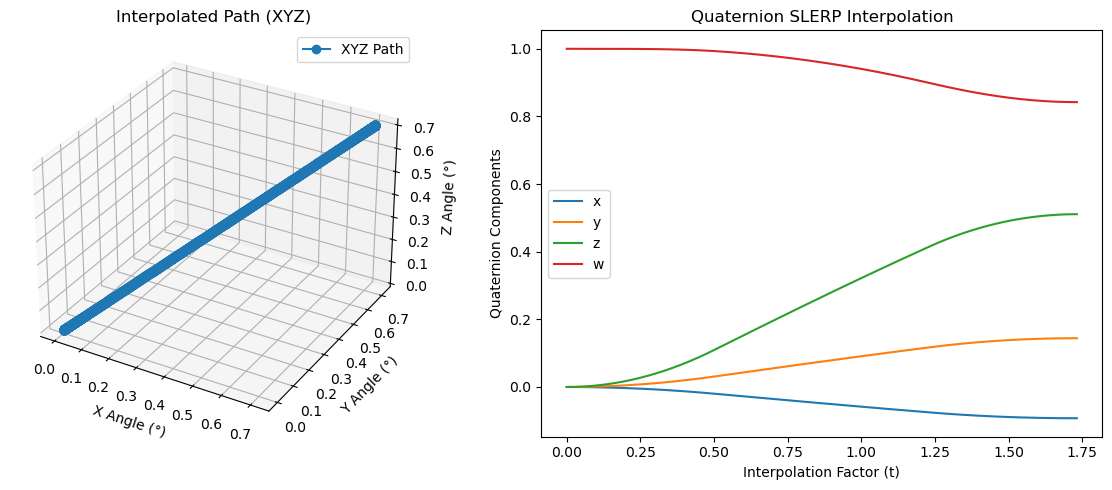

In [442]:
# Plot Euler angles (X, Y, Z)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], marker='o', label="XYZ Path")
ax1.set_xlabel("X Angle (°)")
ax1.set_ylabel("Y Angle (°)")
ax1.set_zlabel("Z Angle (°)")
ax1.set_title("Interpolated Path (XYZ)")
ax1.legend()

# Plot Quaternions (x, y, z, w)
ax2 = fig.add_subplot(122)
ax2.plot(time_arr, orientation_points[:, 0], label="x")
ax2.plot(time_arr, orientation_points[:, 1], label="y")
ax2.plot(time_arr, orientation_points[:, 2], label="z")
ax2.plot(time_arr, orientation_points[:, 3], label="w")
ax2.set_xlabel("Interpolation Factor (t)")
ax2.set_ylabel("Quaternion Components")
ax2.set_title("Quaternion SLERP Interpolation")
ax2.legend()

plt.tight_layout()
plt.show()